In [1]:
import os
from graspy.utils import augment_diagonal,binarize,pass_to_ranks,remove_loops,to_laplace
from graspy.cluster import GaussianCluster, KMeansCluster

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import seaborn as sns
import pandas as pd
import networkx as nx
import community as community
from collections import Counter

from src.cluster import BinaryCluster
from src.data import load_metagraph
from src.graph import MetaGraph
from src.hierarchy import signal_flow
from src.io import savecsv, savefig
from src.utils import get_paired_inds
from src.hierarchy import signal_flow
from src.visualization import CLASS_COLOR_DICT
np.random.seed(8888)

#from karateclub import EgoNetSplitter
#sns.set_style("white")
sns.color_palette("deep")
sns.set_context("talk", font_scale=1)

In [2]:
def create_egonets_ConnComp(G):
    G.components = {}
    G.personalities = {}
    G.index = 0
    for node in G.nodes():
        ego_net_minus_ego = G.subgraph(G.neighbors(node))
        components = {i: n for i, n in enumerate(nx.connected_components(ego_net_minus_ego))} # i=#conn. comp. n=v in conn. comp.
        new_mapping = {}
        personalities = []
        for k, v in components.items():
            personalities.append(G.index)
            for other_node in v:
                new_mapping[other_node] = G.index
            G.index = G.index+1
        G.components[node] = new_mapping
        G.personalities[node] = personalities

In [3]:
def create_egonets_Community(G):
    G.components = {}
    G.personalities = {}
    G.index = 0
    for node in G.nodes():
        ego_net_minus_ego = G.subgraph(G.neighbors(node))
        compo = community.best_partition(ego_net_minus_ego)
        components = Counter(compo.values())
        new_mapping = {}
        personalities = []
        for k in components.keys():
            personalities.append(G.index)
            for other_node in [n for n in compo if compo.get(n)==k]:
                new_mapping[other_node] = G.index
            G.index = G.index+1
        G.components[node] = new_mapping
        G.personalities[node] = personalities

In [4]:
def create_egonets_Cluster(G, method, max_clus):
    G.components = {}
    G.personalities = {}
    G.index = 0
    if method == "GMM":
        GMM = GaussianCluster(min_components=1, max_components=max_clus, n_init=10, covariance_type='all')
    elif method == "KMeans":
        Kmeans = KMeansCluster(max_components=max_clus)
    for node in G.nodes():
        ego_net_minus_ego = G.subgraph(G.neighbors(node))
        Adj = nx.adjacency_matrix(ego_net_minus_ego).toarray()
        if method == "GMM":
            compo= GMM.fit_predict(Adj)
        elif method == "KMeans":
            compo = Kmeans.fit_predict(Adj)

        new_mapping = {}
        personalities = []
        for k in np.unique(compo):
            personalities.append(G.index)
            other_nodes = np.where(compo==np.unique(compo)[k])
            other_nodes = np.asarray(other_nodes).reshape(-1,1)
            for other_node in range(len(other_nodes)):
                new_mapping[other_nodes[other_node][0]] = G.index
            G.index = G.index+1
        G.components[node] = new_mapping
        G.personalities[node] = personalities

In [5]:
def create_persona_graph(G):
    G.persona_graph_edges = [(G.components[e[0]][e[1]], G.components[e[1]][e[0]]) for e in G.edges()]
    G.persona_graph = nx.from_edgelist(G.persona_graph_edges)
    
def create_partitions(G, resolution = 1):
    G.personality_map = {p: n for n in G.nodes() for p in G.personalities[n]}
    G.partitions = community.best_partition(G.persona_graph, resolution=resolution)
    G.overlapping_partitions = {node: [] for node in G.nodes()}
    for node, membership in G.partitions.items():
        G.overlapping_partitions[G.personality_map[node]].append(membership)

In [6]:
os.chdir('/Users/TingshanLiu/Desktop/2020 summer/TL_maggot/maggot_repo')

graph_type = "G"
master_mg = load_metagraph(graph_type)
mg = master_mg.remove_pdiff()
meta = mg.meta

degrees = mg.calculate_degrees()
quant_val = np.quantile(degrees["Total edgesum"], 0.05)
idx = meta[degrees["Total edgesum"] > quant_val].index
print(quant_val)
mg = mg.reindex(idx, use_ids=True)

idx = mg.meta[mg.meta["hemisphere"].isin(["L", "R"])].index
mg = mg.reindex(idx, use_ids=True)

idx = mg.meta[mg.meta["pair"].isin(mg.meta.index)].index
mg = mg.reindex(idx, use_ids=True)

mg = mg.make_lcc()
mg.calculate_degrees(inplace=True)

meta = mg.meta
meta["pair_td"] = meta["pair_id"].map(meta.groupby("pair_id")["Total degree"].mean())
mg = mg.sort_values(["pair_td", "pair_id"], ascending=False)
meta["inds"] = range(len(meta))
adj = mg.adj.copy()
lp_inds, rp_inds = get_paired_inds(meta)
left_inds = meta[meta["left"]]["inds"]

print(f"Neurons left after preprocessing: {len(mg)}")

10.0
Neurons left after preprocessing: 2322


In [18]:
#mg = mg.sort_values(["class1"])
#meta = mg.meta
#adj = mg.adj

G = nx.to_networkx_graph(adj)
create_egonets_Community(G)
#create_persona_graph(G)
#create_partitions(G, resolution = 1)

In [19]:
ncontexts = np.zeros(len(adj))
for i in range(len(ncontexts)):
    ncontexts[i] = len(G.personalities[i])

In [20]:
#labels_exist = np.unique(mg["merge_class"].values)
labels_exist = np.unique(mg["class1"].values)
labels_ordered = []
for i in range(len(CLASS_COLOR_DICT)):
    labels_ordered.append(list(CLASS_COLOR_DICT.keys())[i])
labels_ordered = [item for item in labels_ordered if item in labels_exist]
    

In [143]:
data = pd.DataFrame(data = ncontexts)
#data["label"] = meta["merge_class"].values
data["label"] = meta["class1"].values
data.rename(columns={0:"# personalities", "label": "class label"}, inplace = True)
#data["4colors"] = meata[]
#fig,ax = plt.subplots(1, figsize = (18,16))
fig = sns.catplot(data = data, y = "class label", x = "# personalities", kind = "bar", palette=CLASS_COLOR_DICT, height = 15, order=labels_ordered)
fig.set(title = "Connected component")

plt.close()
#plt.savefig('1⁩-1')

In [142]:
# #personalities V. dendrite_input or axon_input or sf

data = pd.DataFrame(data = ncontexts)
data["sf"] = -signal_flow(adj)
data["axon_input"] = meta["axon_input"].values; data["dendrite_input"] = meta["dendrite_input"].values
data.rename(columns={0:"# personalities"}, inplace = True)
data["# personalities"] = data["# personalities"].astype(int)
fig,(ax1,ax2,ax3) = plt.subplots(3,1,figsize=(10,12))
sns.boxplot(data = data, x = "# personalities", y = "axon_input",ax = ax1)
sns.boxplot(data = data, x = "# personalities", y = "dendrite_input",ax = ax2)
sns.boxplot(data = data, x = "# personalities", y = "sf",ax = ax3)
ax1.set(xlabel = "", ylabel = "axon input", title = "Connected component"); ax2.set(xlabel = "", ylabel = "dendrite input"); ax3.set(ylabel = "signal flow")
plt.close()
#plt.savefig('2-1')

In [10]:
connector_path = "maggot_models/data/processed/2020-05-08/connectors.csv"
connectors = pd.read_csv(connector_path)

In [11]:
from src.spatial import spatial_dcorr

ids = meta.index.values
skid = ids[0]
rows = []
for skid in ids:
    inputs = connectors[connectors[f"postsynaptic_to"] == skid]
    inputs = inputs[~inputs["connector_id"].duplicated(keep="first")]
    outputs = connectors[connectors[f"presynaptic_to"] == skid]
    outputs = outputs[~outputs["connector_id"].duplicated(keep="first")]
    data1 = inputs[["x", "y", "z"]].values
    data2 = outputs[["x", "y", "z"]].values
    stat, p_val = spatial_dcorr(data1, data2)
    row = {"stat": stat, "p_val": p_val, "skid": skid}
    rows.append(row)

In [21]:
data = pd.DataFrame(data = ncontexts)

In [13]:
stats = np.zeros(len(rows))
for i in range(len(rows)):
    j = []
    for k, v in rows[i].items():
        j.append(v)
    stats[i] = j[1]

[Text(0, 0.5, '# personalities \n (conn. comp. based)'),
 Text(0.5, 0, 'p-value')]

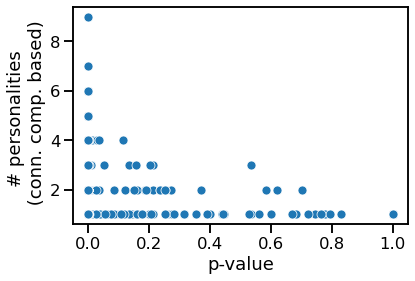

In [15]:
fig = sns.scatterplot(x = stats, y = data[0])
fig.set(xlabel = "p-value", ylabel = "# personalities \n (conn. comp. based)")

In [22]:
nodes = meta.index.values
lengths = np.zeros(len(nodes))
for i in range(len(nodes)):
    presyn = connectors[connectors["presynaptic_to"]==meta.index.values[i]][["x","y","z"]]
    postsyn = connectors[connectors["postsynaptic_to"]==meta.index.values[i]][["x","y","z"]]
    max_x = np.max(pd.DataFrame(pd.concat([presyn["x"],postsyn["x"]]))["x"])
    min_x = np.min(pd.DataFrame(pd.concat([presyn["x"],postsyn["x"]]))["x"])
    max_y = np.max(pd.DataFrame(pd.concat([presyn["y"],postsyn["y"]]))["y"])
    min_y = np.min(pd.DataFrame(pd.concat([presyn["y"],postsyn["y"]]))["y"])
    max_z = np.max(pd.DataFrame(pd.concat([presyn["z"],postsyn["z"]]))["z"])
    min_z = np.min(pd.DataFrame(pd.concat([presyn["z"],postsyn["z"]]))["z"])
    lengths[i] = np.sqrt((max_x - min_x) ** 2 + (max_y - min_y) ** 2 + (max_z - min_z) ** 2)


[Text(0, 0.5, '# personalities'),
 Text(0.5, 0, 'estimated range of connections'),
 Text(0.5, 1.0, 'Louvain modularity')]

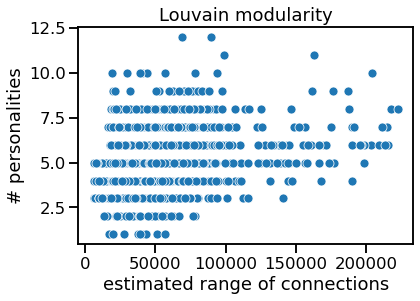

In [23]:
fig = sns.scatterplot(x = lengths, y = data[0])
fig.set(xlabel = "estimated range of connections", ylabel = "# personalities", title = "Louvain modularity")

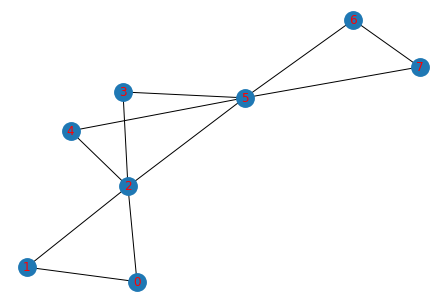

In [8]:
# example graph 

g = np.zeros((8,8))
g[0,1]=1;g[0,2]=1; g[1,2]=1; g[2,3]=1;g[2,4]=1;g[2,5]=1; g[3,5]=1; g[4,5]=1; g[5,6]=1;g[5,7]=1; g[6,7]=1
g = nx.to_networkx_graph(g)
nx.draw(g, with_labels = True, font_color = 'r')
plt.show()
np.random.seed(8888)

In [144]:
#import sys
#!{sys.executable} -m pip install pymaid==1.1.2